In [1]:
# Data manipulation
# ==============================================================================
import warnings
import shap
import math
from skforecast.utils import load_forecaster
from skforecast.utils import save_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoreg import ForecasterAutoreg
import skforecast
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from IAT_dataparser import IATDataParser

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================


# Warnings configuration
# ==============================================================================
warnings.filterwarnings('once')

print('Skforecast version: ', skforecast.__version__)

c:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\net-pred\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
scapy.loading WARNING Wireshark is installed, but cannot read manuf !


Biflow packet data:  {'timestamp': [1619005758.091158, 1619005758.183335], 'src_port': [67, 67], 'dst_port': [68, 68], 'packet_dir': [1, 1], 'IP_packet_bytes': [328, 328], 'IP_header_bytes': [20, 20], 'L4_payload_bytes': [300, 300], 'L4_header_bytes': [8, 8], 'iat': [0.0, 0.092177], 'TCP_win_size': [0, 0], 'TCP_flags': ['', ''], 'L4_raw_payload': [[2, 1, 6, 0, 27, 101, 65, 23, 0, 0, 0, 0, 0, 0, 0, 0, 192, 168, 20, 111, 192, 168, 20, 254, 0, 0, 0, 0, 248, 207, 197, 208, 13, 156, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [2]:
# csv_file1 = r'C:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\dataset_exploration\saved_dataframes\biflow_15.csv'
csv_file1 = r'C:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\dataset_exploration\saved_dataframes\biflow_67.csv'
# csv_file1 = r'C:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\dataset_exploration\saved_dataframes\biflow_77.csv'

test_IAT = pd.read_csv(csv_file1)

test_IAT = test_IAT[100:1100]

Steps:  200
Train dates : 100 --- 899  (n=800)
Test dates  : 900 --- 1099  (n=200)


c:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\net-pred\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


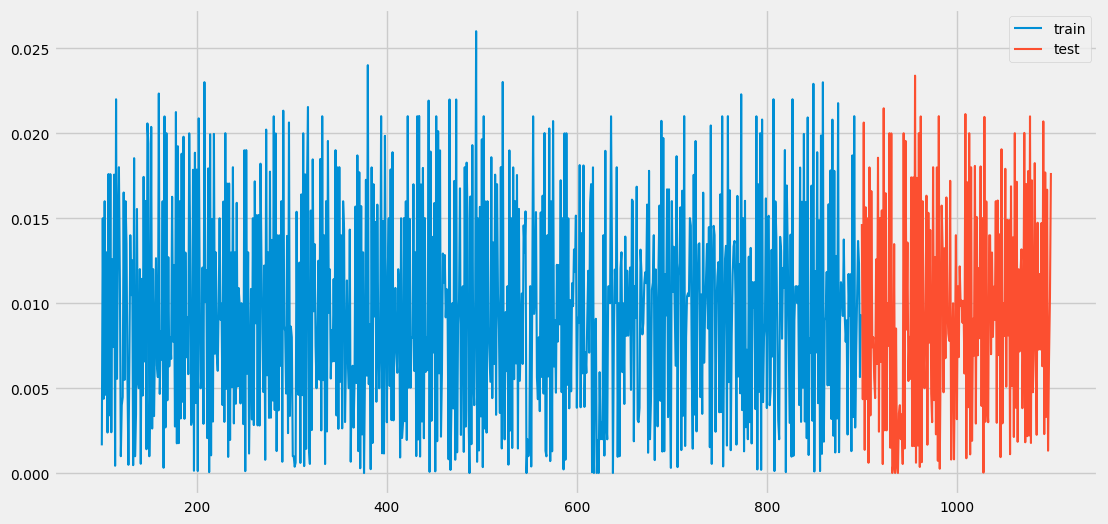

In [3]:
# Split data into train-test
# ==============================================================================
steps = len(test_IAT) * 0.2  # 80/20 split
steps = math.floor(steps)
print("Steps: ", steps)

data_train = test_IAT[:-steps]
data_test = test_IAT[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(12, 6))
data_train['Interarrival'].plot(ax=ax, label='train')
data_test['Interarrival'].plot(ax=ax, label='test')
ax.legend()

In [4]:
def get_lag_list(lag, gap=None):
    """
    Returns a list of integers from 1 to lag, optionally accounting for a specified gap.

    Parameters:
    - lag (int): The end of the range.
    - gap (int, optional): The gap to account for. If specified, only values greater than the gap are included.

    Returns:
    - list: A list of integers.
    """
    if gap is None:
        return list(range(1, lag + 1))
    else:
        return list(range(gap + 1, lag + 1))

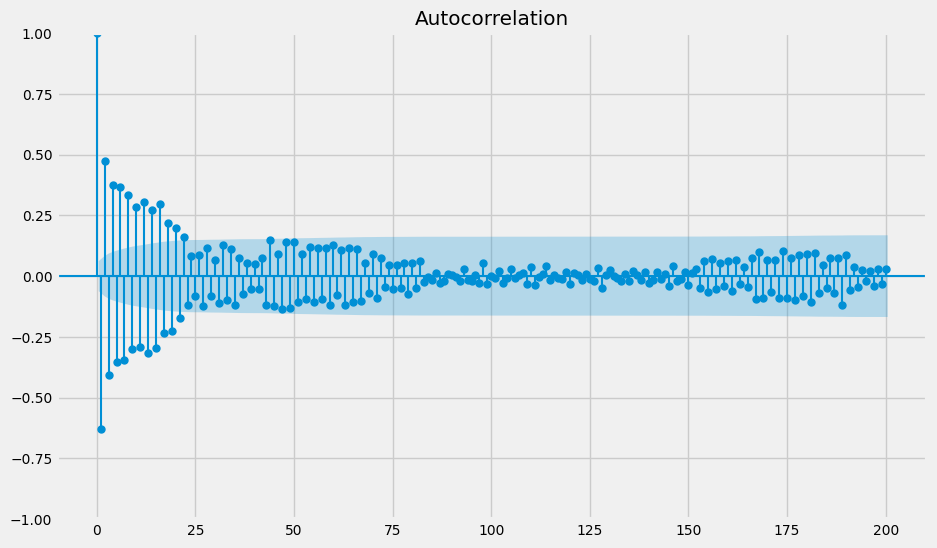

In [8]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 6))
# plot_acf(test_IAT['Interarrival'], ax=ax, lags=get_lag_list(270, 180))
plot_acf(test_IAT['Interarrival'], ax=ax, lags=200)
plt.show()

In [9]:
from tqdm import tqdm

def optimal_lag(data_train, data_test, start, end, step=1):
    losses = []
    lags = []

    for lag in tqdm(range(start, end, step)):
        lags.append(lag)
        forecaster = ForecasterAutoreg(
            regressor=RandomForestRegressor(random_state=123),
            lags=lag
        )

        forecaster.fit(y=data_train['Interarrival'])

        predictions = forecaster.predict(steps=200)

        error_mse = mean_squared_error(
            y_true=data_test['Interarrival'],
            y_pred=predictions
        )

        losses.append(error_mse)

    return losses, lags

100%|██████████| 40/40 [03:44<00:00,  5.61s/it]


Lags:  [1, 21, 41, 61, 81, 101, 121, 141, 161, 181, 201, 221, 241, 261, 281, 301, 321, 341, 361, 381, 401, 421, 441, 461, 481, 501, 521, 541, 561, 581, 601, 621, 641, 661, 681, 701, 721, 741, 761, 781]


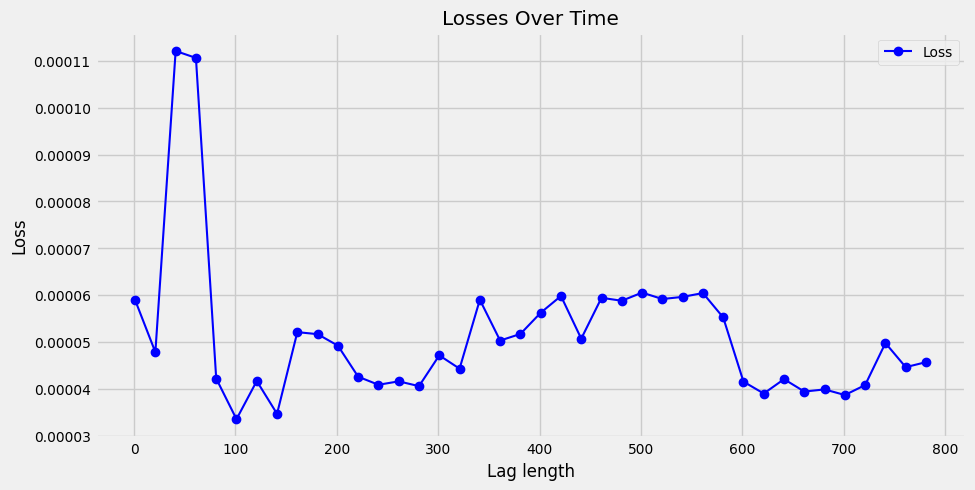

In [16]:
# losses, lags = optimal_lag(data_train, data_test, 1, 270, 20)
losses, lags = optimal_lag(data_train, data_test, 1, len(data_train), 20)
# losses, lags = optimal_lag(data_train, data_test, 1, 200, 20)

print("Lags: ", lags)
# lags = list(range(steps, len(data_train), 10))
    
# Ensure the length of losses matches the length of lags
if len(losses) != len(lags):
    raise ValueError("The length of losses must match the number of lags generated by the specified range.")

plt.figure(figsize=(10, 5))
plt.plot(lags, losses, marker='o', linestyle='-', color='b', label='Loss')
plt.title('Losses Over Time')
plt.xlabel('Lag length')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# A naive approach
# Create and train forecaster
# We look into the past 100 readings and try to predict the next 30
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123),
    # lags=get_lag_list(steps, 0)
    lags=100
)
forecaster.fit(y=data_train['Interarrival'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56] 
Transformer for y: None 
Transformer for exog: None 
Window size: 56 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [100, 899] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: 

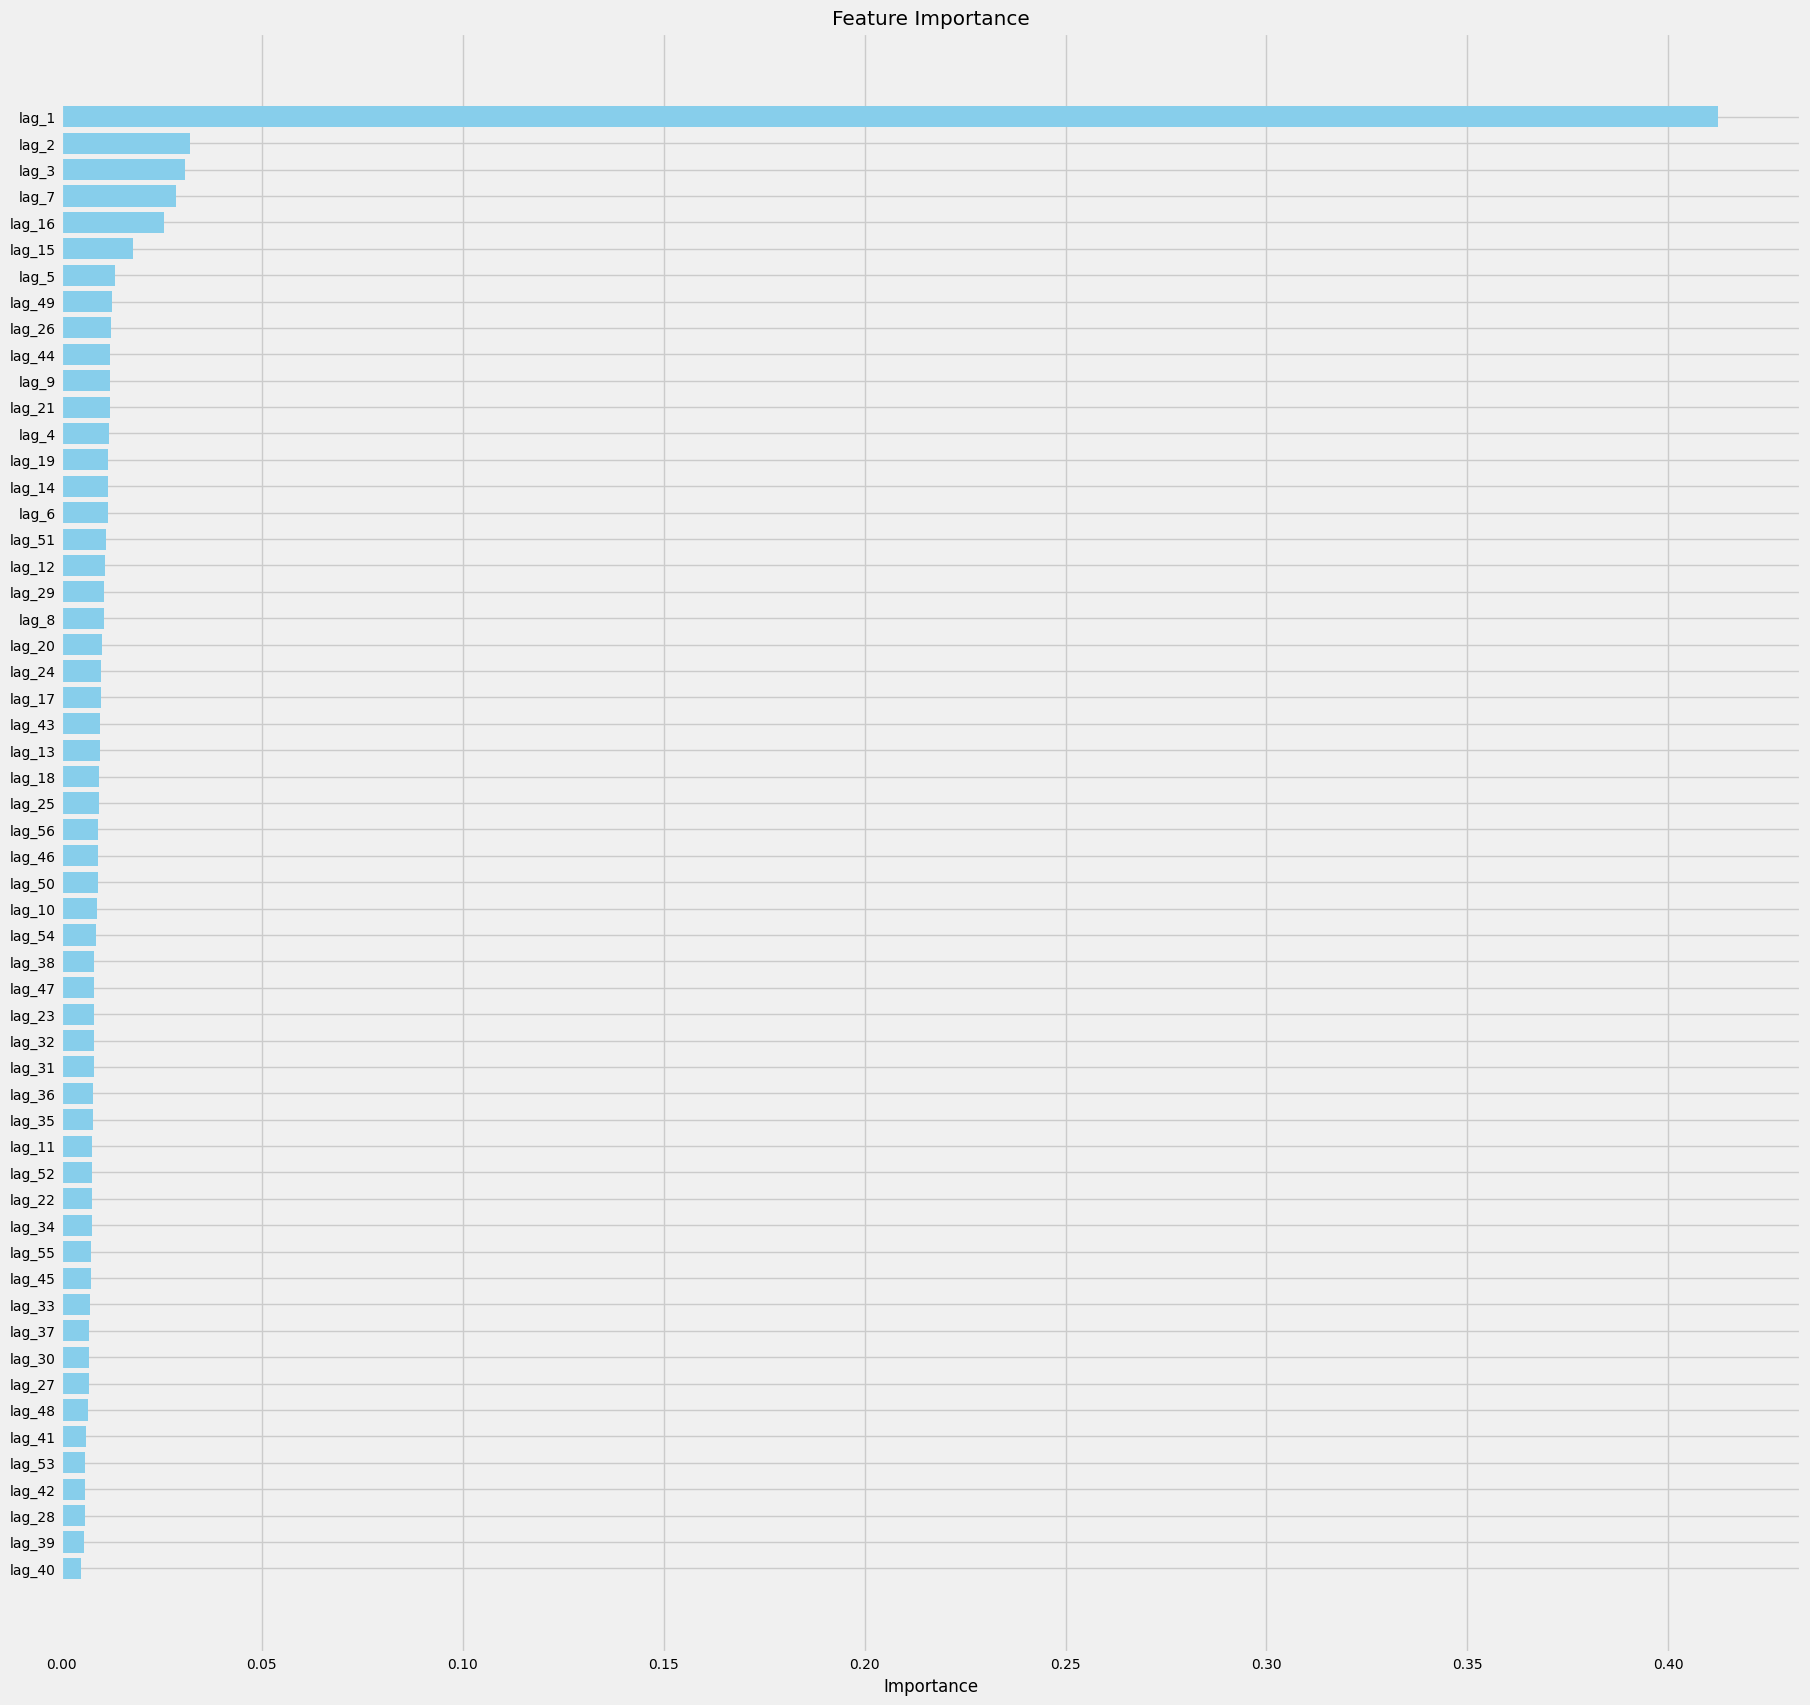

In [12]:
# Retrieving feature importance
feat_impt_df = forecaster.get_feature_importances()

# # Sort DataFrame by importance
# feat_impt_df = feat_impt_df.sort_values(by='importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(20, 20))
plt.barh(feat_impt_df['feature'], feat_impt_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

In [13]:
# Predictions
# ==============================================================================
# steps = 80
print("Steps: ", steps)
predictions = forecaster.predict(steps=200)
predictions.head(5)

Steps:  200


900    0.010133
901    0.010170
902    0.010320
903    0.009807
904    0.010172
Name: pred, dtype: float64

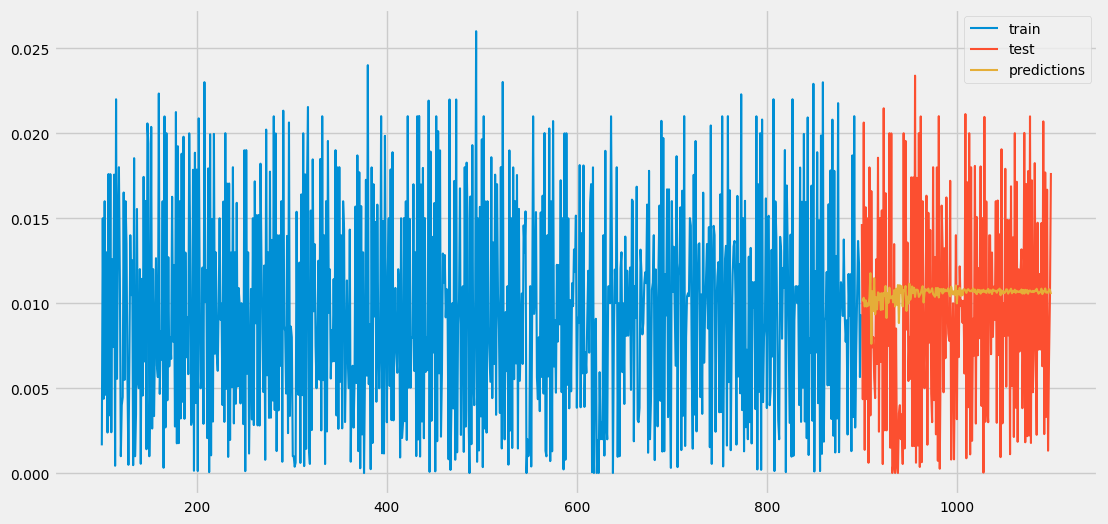

In [14]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 6))
data_train['Interarrival'].plot(ax=ax, label='train')
data_test['Interarrival'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [18]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
    y_true=data_test['Interarrival'],
    y_pred=predictions
)
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.00016397727290157947


In [19]:
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123),
    # lags=get_lag_list(steps, 0)
    lags=200
)
forecaster.fit(y=data_train['Interarrival'])

In [20]:
from skforecast.model_selection import backtesting_forecaster

metric, predictions_training = backtesting_forecaster(
    forecaster=forecaster,
    y=data_train['Interarrival'],
    steps=1,
    metric='mean_squared_error',
    initial_train_size=None,
    refit=False,
    verbose=False,
    show_progress=True
)

print(f"Backtest training error: {metric}")

  0%|          | 0/600 [00:00<?, ?it/s]

100%|██████████| 600/600 [00:01<00:00, 341.58it/s]


Backtest training error: 4.18757689194676e-05


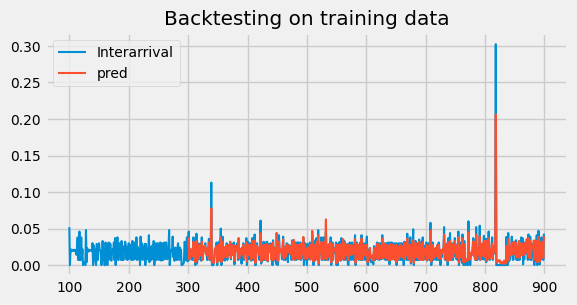

In [21]:
# Plot training predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_train['Interarrival'].plot(ax=ax)
predictions_training.plot(ax=ax)
ax.set_title("Backtesting on training data")
ax.legend()
plt.show()

In [22]:
# Backtesting
# ==============================================================================
steps = 141
n_backtesting = 141*4  # The last 9 years are separated for the backtest
metric, predictions_backtest = backtesting_forecaster(
    forecaster=forecaster,
    y=data_train['Interarrival'],
    initial_train_size=len(data_train) - n_backtesting,
    fixed_train_size=False,
    steps=steps,
    metric='mean_squared_error',
    refit=True,
    verbose=True,
    show_progress=True
)
print(f"Backtest metric (MSE): {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 236
Number of observations used for backtesting: 564
    Number of folds: 4
    Number of steps per fold: 141
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   100 -- 335  (n=236)
    Validation: 336 -- 476  (n=141)
Fold: 1
    Training:   100 -- 476  (n=377)
    Validation: 477 -- 617  (n=141)
Fold: 2
    Training:   100 -- 617  (n=518)
    Validation: 618 -- 758  (n=141)
Fold: 3
    Training:   100 -- 758  (n=659)
    Validation: 759 -- 899  (n=141)



100%|██████████| 4/4 [00:00<00:00, 91.73it/s]


Backtest metric (MSE): 0.00033452601200867485
